In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from zipfile import ZipFile
with ZipFile('drive/MyDrive/archive.zip','r') as zipObj:
  zipObj.extractall()


In [ ]:
import os
base_dir = 'DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, 'O')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, 'O')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, 'R')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 12565
total training recycyle images: 9999
total validation organic images: 1401
total validation recycyle images: 1112


(209, 236, 3)
(183, 275, 3)
(225, 225, 3)
(225, 225, 3)
(160, 314, 3)
(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


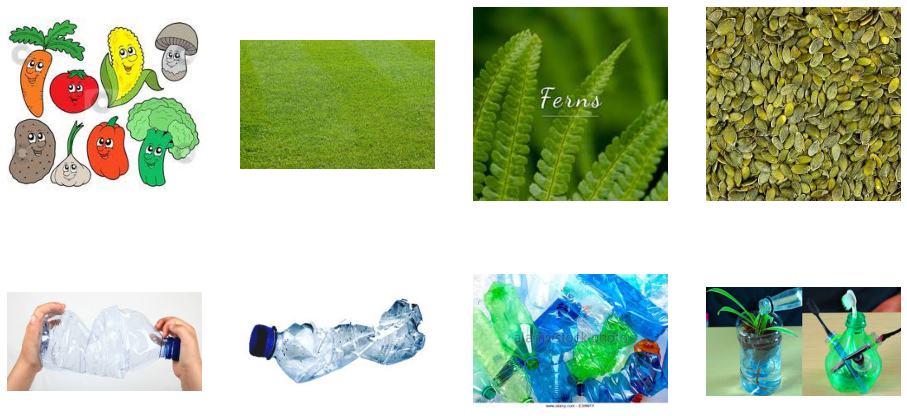

In [ ]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname)
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname)
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  print(img.shape)

plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
706/706 - 44s - loss: 0.4854 - acc: 0.7938 - val_loss: 0.3201 - val_acc: 0.8938 - 44s/epoch - 62ms/step
Epoch 2/10
706/706 - 37s - loss: 0.3986 - acc: 0.8308 - val_loss: 0.2740 - val_acc: 0.9081 - 37s/epoch - 52ms/step
Epoch 3/10
706/706 - 37s - loss: 0.3754 - acc: 0.8453 - val_loss: 0.3307 - val_acc: 0.8619 - 37s/epoch - 53ms/step
Epoch 4/10
706/706 - 39s - loss: 0.3579 - acc: 0.8564 - val_loss: 0.3857 - val_acc: 0.8559 - 39s/epoch - 55ms/step
Epoch 5/10
706/706 - 38s - loss: 0.3482 - acc: 0.8608 - val_loss: 0.3187 - val_acc: 0.8762 - 38s/epoch - 53ms/step
Epoch 6/10
706/706 - 36s - loss: 0.3390 - acc: 0.8647 - val_loss: 0.3794 - val_acc: 0.8663 - 36s/epoch - 51ms/step
Epoch 7/10
706/706 - 35s - loss: 0.3388 - acc: 0.8680 - val_loss: 0.2854 - val_acc: 0.8882 - 35s/epoch - 49ms/step
Epoch 8/10
706/706 - 35s - loss: 0.3297 - acc: 0.8695 - val_loss: 0.4464 - val_acc: 0.8822 - 35s/epoch - 49ms/step
Epoch 9/10
706/706 - 35s - loss: 0.3288 - acc: 0.8698 - val_loss: 0.2923 - val_a

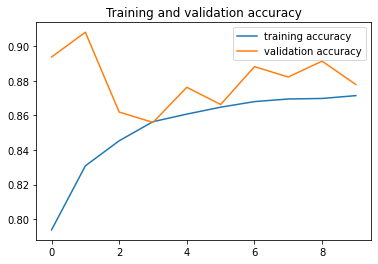

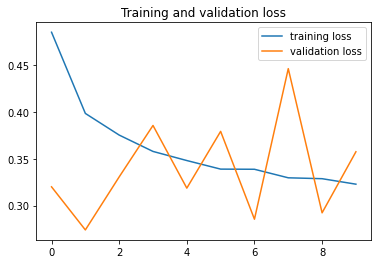

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
# loading in the Inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
  layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

--2022-11-07 15:08:55--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  15.3MB/s    in 6.9s    

2022-11-07 15:09:03 (12.1 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape: (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Configure the model
model = Model(pre_trained_model.input, x)

# As an optimizer, here we will use SGD
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001,
                  momentum=0.9),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                            

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/60
100/100 - 13s - loss: 0.7045 - acc: 0.5288 - val_loss: 0.6757 - val_acc: 0.5831 - 13s/epoch - 131ms/step
Epoch 2/60
100/100 - 8s - loss: 0.6827 - acc: 0.5713 - val_loss: 0.6543 - val_acc: 0.6125 - 8s/epoch - 79ms/step
Epoch 3/60
100/100 - 8s - loss: 0.6483 - acc: 0.6278 - val_loss: 0.6355 - val_acc: 0.6431 - 8s/epoch - 79ms/step
Epoch 4/60
100/100 - 8s - loss: 0.6289 - acc: 0.6562 - val_loss: 0.6204 - val_acc: 0.6669 - 8s/epoch - 80ms/step
Epoch 5/60
100/100 - 8s - loss: 0.6296 - acc: 0.6503 - val_loss: 0.6027 - val_acc: 0.7131 - 8s/epoch - 81ms/step
Epoch 6/60
100/100 - 8s - loss: 0.6025 - acc: 0.6966 - val_loss: 0.5864 - val_acc: 0.7412 - 8s/epoch - 79ms/step
Epoch 7/60
100/100 - 8s - loss: 0.5861 - acc: 0.7103 - val_loss: 0.5680 - val_acc: 0.7656 - 8s/epoch - 78ms/step
Epoch 8/60
100/100 - 8s - loss: 0.5727 - acc: 0.7475 - val_loss: 0.5648 - val_acc: 0.7613 - 8s/epoch - 78ms/step
Epoch 9/60
100/100 - 8s - loss: 0.5596 - acc: 0.7531 - val_loss: 0.5445 - val_acc: 0.8000 - 8

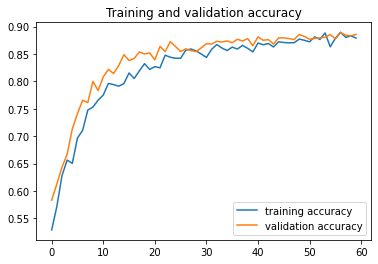

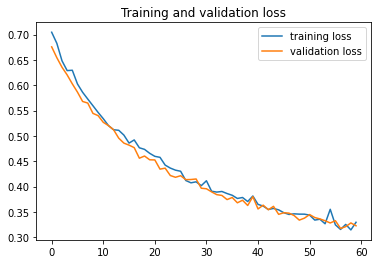

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [ ]:
val_pred_prob = model.predict(val_visual)

79/79 [==============================] - 5s 58ms/step


In [ ]:
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'
#testing the model on external validation set
# getting predictions in the form of probablities
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

79/79 [==============================] - 4s 52ms/step
Model predictions: [0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,

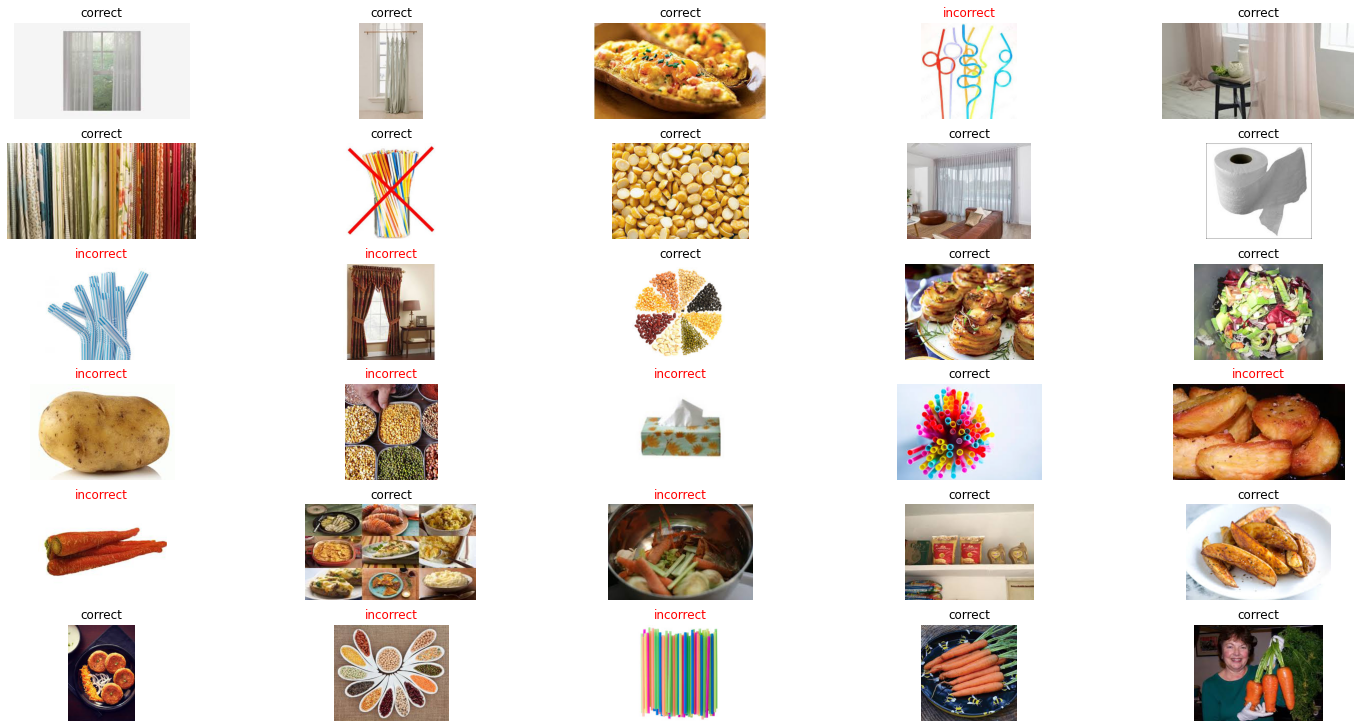

In [ ]:
# obtain images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plot first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1
plt.show()

In [ ]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

79/79 [==============================] - 4s 55ms/step - loss: 0.3278 - acc: 0.8794
Accuracy using evaluate: 0.8794269561767578
Loss using evaluate: 0.32775768637657166


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1071   41]
 [ 521  880]] 

Outcome values : 
 880 521 41 1071 

Classification report : 
               precision    recall  f1-score   support

           1       0.96      0.63      0.76      1401
           0       0.67      0.96      0.79      1112

    accuracy                           0.78      2513
   macro avg       0.81      0.80      0.78      2513
weighted avg       0.83      0.78      0.77      2513

